In [1]:
!pip install astropy

  Using cached astropy-7.0.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached pyerfa-2.0.1.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.7 kB)
  Using cached astropy_iers_data-0.2024.12.9.0.36.21-py3-none-any.whl.metadata (5.1 kB)
Using cached astropy-7.0.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)
Using cached astropy_iers_data-0.2024.12.9.0.36.21-py3-none-any.whl (1.9 MB)
Using cached pyerfa-2.0.1.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (738 kB)


In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os

%matplotlib inline
# plt.rc('font', family='Times New Roman')
plt.rc('font', family='Sans-serif')
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', linewidth=2)
plt.rcParams['figure.figsize'] = (8, 5)

In [3]:
hdulist = fits.open('tess2019198215352-s0014-0000000424865156-0150-s_lc.fits')
hdulist.info()     

Filename: tess2019198215352-s0014-0000000424865156-0150-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   19337R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


In [4]:
head = hdulist[0].header
spec = hdulist[1].data

In [5]:
filtered_time = spec['TIME'][~np.isnan(spec['SAP_FLUX'])]
filtered_flux = spec['SAP_FLUX'][~np.isnan(spec['SAP_FLUX'])]

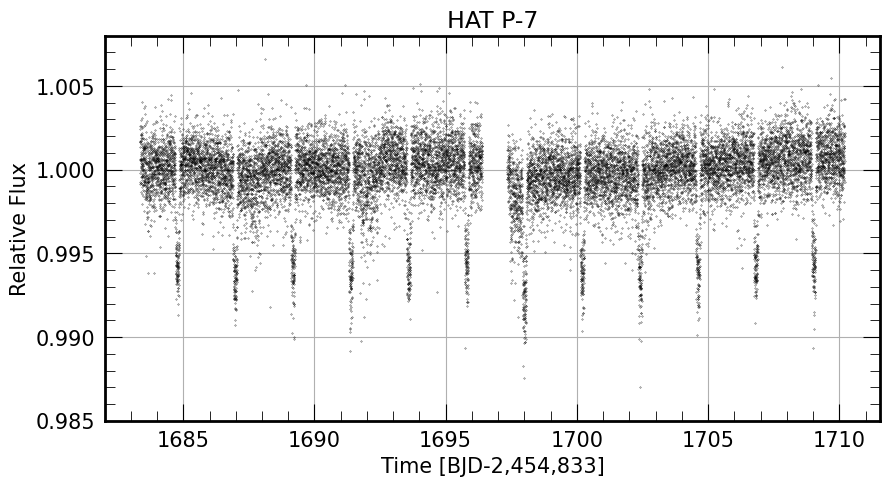

In [6]:
plt.figure(figsize=(10, 5))
plt.ylim(0.985, 1.008) 
plt.title("HAT P-7", fontsize=17)
plt.xlabel('Time [BJD-2,454,833]', fontsize=15)
plt.ylabel('Relative Flux', fontsize=15)
plt.minorticks_on()
plt.tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=12, labelsize=15, pad=7)
plt.tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=7)

plt.plot(filtered_time, filtered_flux/np.median(filtered_flux), '.', c='k', ms=0.5)
plt.grid();

### Synthetic Light Curves

In [7]:
def generate_synthetic_light_curve(time, period, depth, duration, noise_level=0.001, noise_type="gaussian", red_noise_alpha=1.0):
    """
    Generates a synthetic light curve for a transiting exoplanet with a "U-shape" dip and adds noise

    Parameters:
    ==========
    time            : array-like
        - time array over which to generate the light curve
    period          : float
        - orbital period of the exoplanet (in days)
    depth           : float
        - fractional dip in flux during a transit (e.g., 0.01 for 1%)
    duration        : float
        - duration of each transit (in days)
    noise_type      : str
        - type of noise to add ("gaussian", "white", or "red")
    noise_level     : float
        - standard deviation of the noise to be added
    red_noise_alpha : float
        - alpha parameter for red noise (e.g., 1.0 for 1/f noise)

    * Returns a simulated light curve flux values with the specified noise
    """
    # initializing the light curve with baseline flux of 1
    flux = np.ones_like(time)

    # identifying transit times
    transit_centers = np.arange(time[0], time[-1], period)
    
    for center in transit_centers:
        # indices of points within the transit duration
        in_transit = np.abs(time - center) <= (duration / 2)
        
        # parabolic "U-shape" dip
        transit_time = time[in_transit]
        mid_transit = center
        normalized_time = (transit_time - mid_transit) / (duration / 2)
        flux[in_transit] -= depth * (1 - normalized_time**2)

    # adding noise based on the selected type
    if noise_type.lower() == "gaussian":
        flux += np.random.normal(0, noise_level, size=len(time))
    elif noise_type.lower() == "white":
        flux += np.random.uniform(-noise_level, noise_level, size=len(time))
    elif noise_type.lower() == "red":
        red_noise = generate_red_noise(len(time), alpha=red_noise_alpha, std=noise_level)
        flux += red_noise
    else:
        raise ValueError("Invalid noise type. Choose 'gaussian', 'white', or 'red'.")

    return flux


def generate_red_noise(size, alpha=1.0, std=0.001):
    """
    * creates a correlated noise signal that mimics the statistical properties of red noise

    Parameters:
    ==========
    size  : int
        - length of the noise array
    alpha : float
        - power spectrum slope (1/f^alpha)
    std   : float
        - standard deviation of the noise

    * Returns a generated red noise
    """
    # generates the positive frequencies associated with the size of the time-series data
    freqs = np.fft.rfftfreq(size)  
    # avoid division by zero at f = 0
    freqs[0] = 1e-6  
    # 1/f^alpha power spectrum 
    # frequencies with lower values contribute more to the power for larger values of α, 
    # leading to correlated, long-term variations in the noise
    power = 1 / (freqs ** alpha)  
    # generates random values (b/w 0 and 1) for each frequency bin
    random_phases = np.exp(2j * np.pi * np.random.random(len(freqs)))
    # creating a complex Fourier spectrum
    spectrum = np.sqrt(power) * random_phases  # amplitude * phase
    
    # converting the frequency-domain spectrum back into the time domain, resulting in a time-series signal
    red_noise = np.fft.irfft(spectrum, n=size)  # inverse FFT to get red noise in time domain
    # normalize to desired std
    red_noise = (red_noise - np.mean(red_noise)) / np.std(red_noise) * std  
    
    return red_noise

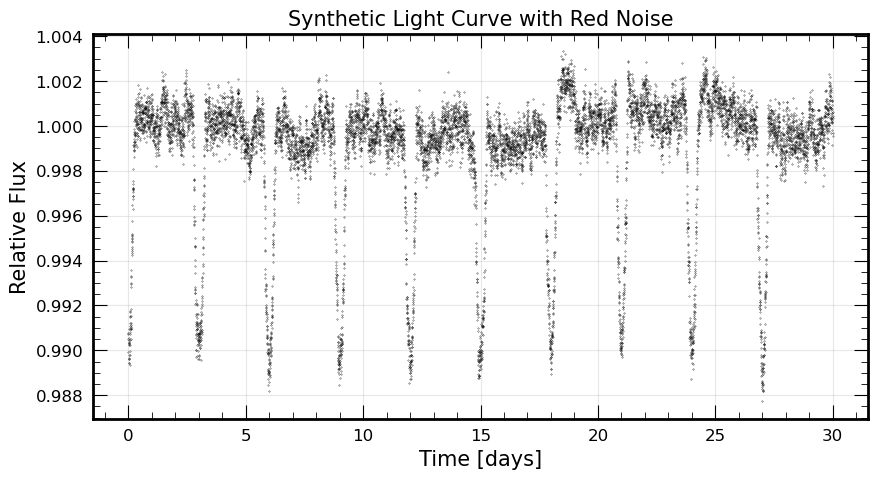

In [20]:
time_red = np.linspace(0, 30, 10000)  # time array in days
period = 3.0                     # orbital period (in days)
depth = 0.01                     # 1% dip in flux
duration = 0.5                   # 0.2 days transit duration
noise_level = 0.0009              # std of Gaussian noise
noise_type = "red"
synthetic_flux_red = generate_synthetic_light_curve(time, period, depth, duration, noise_level, 
                                                    noise_type, red_noise_alpha=1.0)

plt.figure(figsize=(10, 5))
plt.title(f"Synthetic Light Curve with {noise_type.capitalize()} Noise", fontsize=15)
plt.xlabel("Time [days]", fontsize=15)
plt.ylabel("Relative Flux", fontsize=15)
plt.minorticks_on()
plt.tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
plt.tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
plt.plot(time_red, synthetic_flux_red, 'k.', ms=0.5)
plt.grid(alpha=0.3)
plt.show()

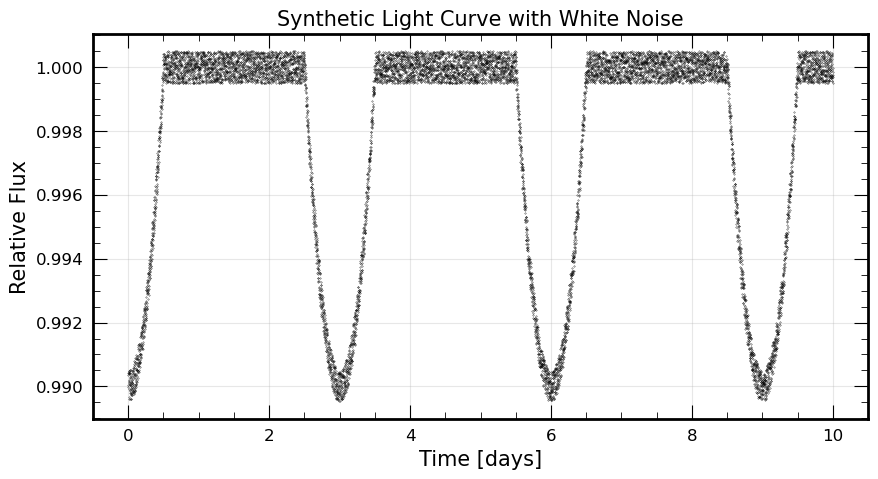

In [27]:
time_white = np.linspace(0, 10, 10000)  # time array in days
period = 3.0                      # orbital period (in days)
depth = 0.01                      # 1% dip in flux
duration = 1                    # 0.2 days transit duration
noise_level = 0.0005               # std of Gaussian noise
noise_type = "white"
synthetic_flux_white = generate_synthetic_light_curve(time, period, depth, duration, noise_level, 
                                                      noise_type, red_noise_alpha=1.0)

plt.figure(figsize=(10, 5))
plt.title(f"Synthetic Light Curve with {noise_type.capitalize()} Noise", fontsize=15)
plt.xlabel("Time [days]", fontsize=15)
plt.ylabel("Relative Flux", fontsize=15)
plt.minorticks_on()
plt.tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
plt.tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
plt.plot(time_white, synthetic_flux_white, 'k.', ms=0.5)
plt.grid(alpha=0.3)
plt.show()

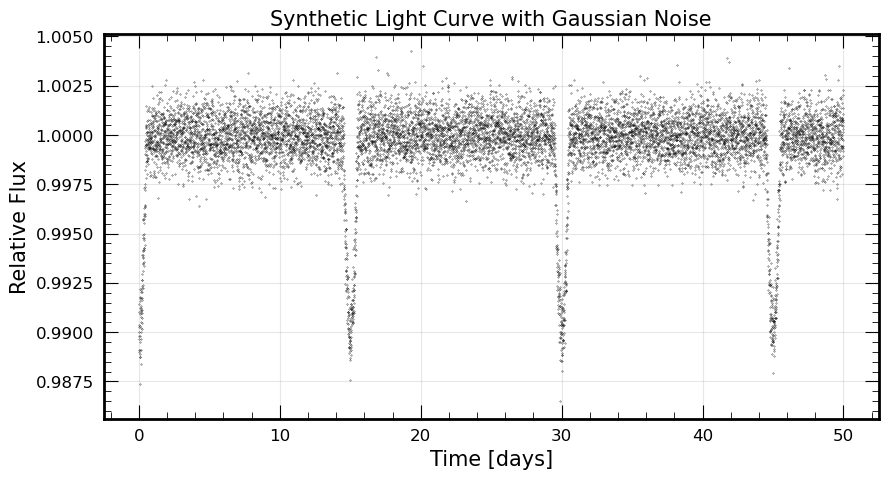

In [30]:
time_gauss = np.linspace(0, 50, 10000)  # time array in days
period = 3.0                      # orbital period (in days)
depth = 0.01                      # 1% dip in flux
duration = 0.2                    # 0.2 days transit duration
noise_level = 0.001               # std of Gaussian noise
noise_type = "gaussian"
synthetic_flux_gauss = generate_synthetic_light_curve(time, period, depth, duration, noise_level, 
                                                      noise_type, red_noise_alpha=1.0)

plt.figure(figsize=(10, 5))
plt.title(f"Synthetic Light Curve with {noise_type.capitalize()} Noise", fontsize=15)
plt.xlabel("Time [days]", fontsize=15)
plt.ylabel("Relative Flux", fontsize=15)
plt.minorticks_on()
plt.tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
plt.tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
plt.plot(time_gauss, synthetic_flux_gauss, 'k.', ms=0.5)
plt.grid(alpha=0.3)
plt.show()

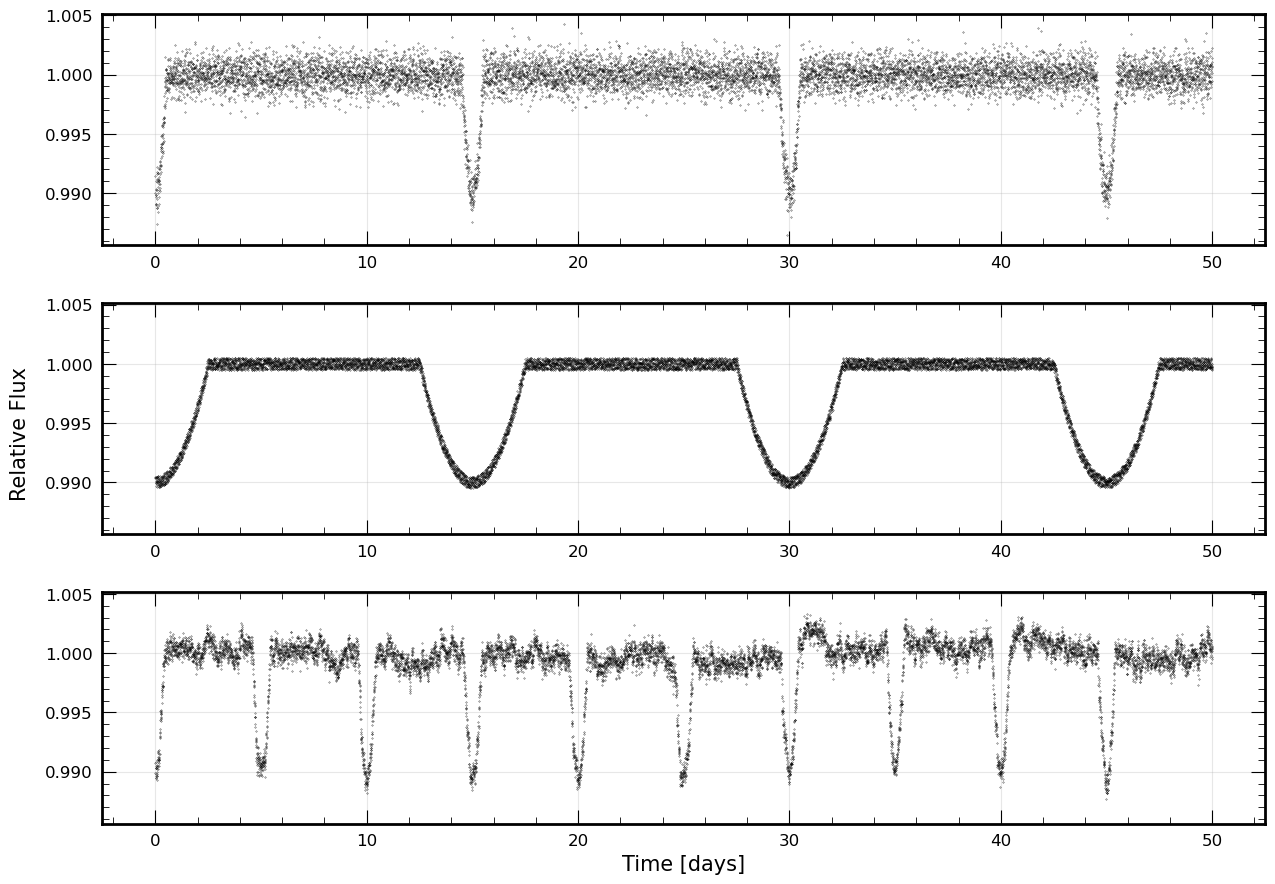

In [46]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharey=True)
hspace = 0.25
wspace = 0.30
fig.subplots_adjust(top=0.92, hspace=hspace, wspace=wspace)

fig.text(0.07, 0.5, 'Relative Flux', va='center', ha='center', rotation='vertical', fontsize=15)

axs[0].minorticks_on()
axs[0].tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
axs[0].tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
axs[0].plot(time_gauss, synthetic_flux_gauss, 'k.', ms=0.5)
axs[0].grid(alpha=0.3)

axs[1].minorticks_on()
axs[1].tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
axs[1].tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
axs[1].plot(time_gauss, synthetic_flux_white, 'k.', ms=0.5)
axs[1].grid(alpha=0.3)

axs[2].set_xlabel("Time [days]", fontsize=15)
axs[2].minorticks_on()
axs[2].tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
axs[2].tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
axs[2].plot(time_gauss, synthetic_flux_red, 'k.', ms=0.5)
axs[2].grid(alpha=0.3)

plt.show()

### False Transits

In [11]:
def generate_false_transit_light_curve(time, dip_probability, depth_range, duration_range,
                                       noise_type, noise_level, red_noise_alpha=1.0):
    """
    * Generates a synthetic light curve with occasional dips and noise

    Parameters:
    ==========
    time            : array-like
        - time array over which to generate the light curve
    dip_probability : float
        - probability of introducing a random dip at each time point
    depth_range     : tuple (min_depth, max_depth)
        - range of depths for the dips (fractional flux)
    duration_range  : tuple (min_duration, max_duration)
        - range of durations for the dips (in days)
    noise_type      : str
        - type of noise to add ("gaussian", "white", or "red")
    noise_level     : float
        - standard deviation of the noise to be added to the light curve
    red_noise_alpha : float
        - power-law index for the red noise (only used if noise_type is "red")

    * Returns a simulated light curve flux values with occasional dips and noise
    """
    # initializing light curve with baseline flux of 1
    flux = np.ones_like(time)

    for t in time:
        # introduce dips based on probability
        if np.random.rand() < dip_probability:  
            dip_center = t
            dip_duration = np.random.uniform(*duration_range)  
            dip_depth = np.random.uniform(*depth_range)  

            # parabolic dip shape
            in_dip = np.abs(time - dip_center) <= (dip_duration / 2)
            normalized_time = (time[in_dip] - dip_center) / (dip_duration / 2)
            flux[in_dip] -= dip_depth * (1 - normalized_time**2)

    # adding noise to the light curve
    if noise_type.lower() == "gaussian":
        flux += np.random.normal(0, noise_level, size=len(time))
    elif noise_type.lower() == "white":
        flux += np.random.uniform(-noise_level, noise_level, size=len(time))
    elif noise_type.lower() == "red":
        red_noise = generate_red_noise(len(time), alpha=red_noise_alpha, std=noise_level)
        flux += red_noise
    else:
        raise ValueError("Invalid noise type. Choose 'gaussian', 'white', or 'red'.")

    return flux

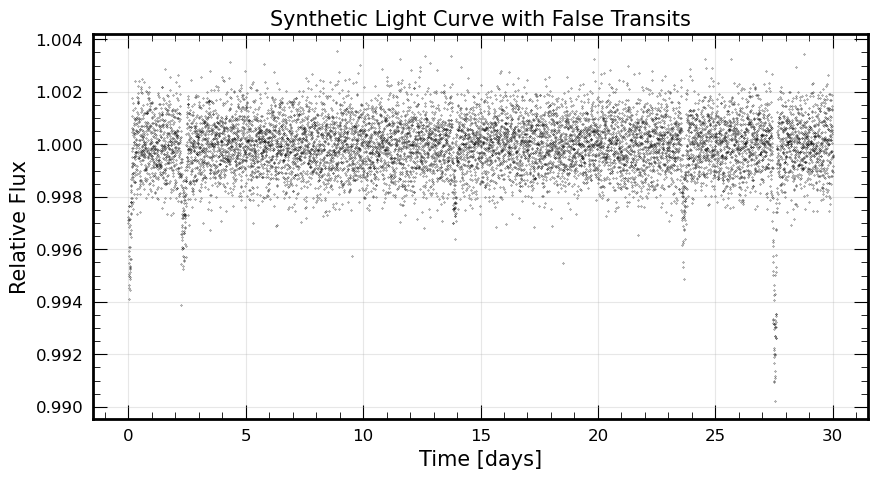

In [50]:
time = np.linspace(0, 30, 10000)  # time (in days), number of datapoints
noise_type = "gaussian"
noise_level = 0.001
dip_probability = 0.0003          # 0.1% transit probability
depth_range = (0.001, 0.008)      # 0.5% ~ 1.0% depth range
duration_range = (0.1, 0.3)       # transit duration (in days)

false_light_curve = generate_false_transit_light_curve(time, dip_probability, depth_range, duration_range,
                                                       noise_type, noise_level, red_noise_alpha=1.0)


plt.figure(figsize=(10, 5))
plt.title("Synthetic Light Curve with False Transits", fontsize=15)
plt.xlabel("Time [days]", fontsize=15)
plt.ylabel("Relative Flux", fontsize=15)
plt.minorticks_on()
plt.tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
plt.tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
plt.plot(time, false_light_curve, 'k.', ms=0.5)
plt.grid(alpha=0.3)
plt.show()

## Stochastic Gradient Descent

### Generating Training Data

In [14]:
def generate_and_save_light_curves(n_data, show_plot=False):
    """
    Generate synthetic light curves for transiting exoplanets or false transits 
    with random parameters and save them as JPG files
    
    Parameters:
    ===========
    n_data    : int
        - number of synthetic light curves to generate
    show_plot : bool
        - whether to display the plot of the generated light curves
    """
    if not os.path.exists("Training_data"):
        os.makedirs("Training_data")
        
    # constraints
    time_range = (30, 100)  # need a longer time range to match test data
    depth_range = (0.001, 0.008)
    duration_range = (0.1, 0.3)
    noise_level_range = (0.0001, 0.005)
    noise_types = ["gaussian", "red", "white"]
    dip_probability_range = (0.0001, 0.001)  

    # file containing the labels
    labels_file = "labels.txt"
    with open(labels_file, "w") as f:
        # headers
        f.write(f"{n_data} total training data\n\n")
        f.write("# attributes: Exoplanet = 1; No exoplanet = 0\n\n")

    # file containing the parameters
    params_file = "parameters.txt"
    with open(params_file, "w") as f:
        # headers
        f.write("# Period \t Duration \t Depth \t Noise \t Noise_level\n")
        f.write("# days \t\t days \t\t % \t\t type \t std_dev\n\n")

    for i in range(1, n_data + 1):
        end_time = np.random.uniform(*time_range)
        time = np.linspace(0, end_time, 10000)
        noise_level = np.random.uniform(*noise_level_range)
        noise_type = np.random.choice(noise_types)
        
        # randomly choose the synthetic flux type
        flux_type = np.random.choice(["transit", "false_transit"])
        
        if flux_type == "transit":
            period = np.random.uniform(0, end_time)
            depth = np.random.uniform(0.001, 0.02)  
            duration = np.random.uniform(0.01, min(period / 3, 50))
            
            # skip invalid cases for transit
            if period <= 0 or duration <= 0 or period < duration:
                print(f"Skipping generation: Invalid period ({period}) or duration ({duration}).")
                continue

            synthetic_flux = generate_synthetic_light_curve(
                                time, period, depth, duration, noise_level=noise_level, 
                                noise_type=noise_type, red_noise_alpha=1.0
                                                            )
            
            # saving the parameters values
            with open(params_file, "a") as f:
                f.write(f"{period} \t {duration} \t {depth} \t {noise_type} \t {noise_level}\n")
                
        elif flux_type == "false_transit":
            dip_probability = np.random.uniform(*dip_probability_range)
            
            
            synthetic_flux = generate_false_transit_light_curve(
                                time, dip_probability, depth_range, duration_range, 
                                noise_type=noise_type, noise_level=noise_level, red_noise_alpha=1.0
                                                                )
            # saving the parameters values
            with open(params_file, "a") as f:
                f.write(f"{np.nan} \t {np.nan} \t {np.nan} \t {noise_type} \t {noise_level}\n")

        plt.figure(figsize=(10, 5))
        plt.plot(time, synthetic_flux, 'k.', ms=0.5)
        plt.grid(alpha=0.3)

        # saving plot without labels to minimize noise during training
        path = "Training_data"
        file = f"{i:05}.jpg"
        filename = f"{path}/{file}"
        plt.savefig(filename, dpi=150, bbox_inches='tight', pad_inches=0.1)

        print(f"Saved image as '{file}'")
        
        # add labels and titles only if show_plot == True
        if show_plot:
            plt.suptitle(f"{'True Exoplanet Transit' if flux_type == 'transit' else 'False Exoplanet Transit'} with {noise_type.capitalize()} Noise", fontsize=15)
            if flux_type == "transit":
                plt.title(f"Period: {period:.1f} days $\quad$ Duration: {duration:.2f} days $\quad$ Depth: {depth:.3f} $\quad$ Noise: {noise_level:.4f}", fontsize=14)
            else:
                plt.title(f"Dip Probability: {dip_probability:.5f} $\quad$ Noise: {noise_level:.4f}", fontsize=14)
            plt.xlabel("Time [days]", fontsize=15)
            plt.ylabel("Relative Flux", fontsize=15)
            plt.minorticks_on()
            plt.tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
            plt.tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
            plt.show()
        
        plt.close()

        # append label to the text file
        with open(labels_file, "a") as f:
            label = 1 if flux_type == "transit" else 0
            f.write(f"{os.path.basename(file)} {label}\n")

In [ ]:
generate_and_save_light_curves(10000, show_plot=False)

Saved image as '00001.jpg'
Saved image as '00002.jpg'
Saved image as '00003.jpg'
Saved image as '00004.jpg'
Saved image as '00005.jpg'
Saved image as '00006.jpg'
Saved image as '00007.jpg'
Saved image as '00008.jpg'
Saved image as '00009.jpg'
Saved image as '00010.jpg'
Saved image as '00011.jpg'
Saved image as '00012.jpg'
Saved image as '00013.jpg'
Saved image as '00014.jpg'
Saved image as '00015.jpg'
Saved image as '00016.jpg'
Saved image as '00017.jpg'
Saved image as '00018.jpg'
Saved image as '00019.jpg'
Saved image as '00020.jpg'
Saved image as '00021.jpg'
Saved image as '00022.jpg'
Saved image as '00023.jpg'
Saved image as '00024.jpg'
Saved image as '00025.jpg'
Saved image as '00026.jpg'
Saved image as '00027.jpg'
Saved image as '00028.jpg'
Saved image as '00029.jpg'
Saved image as '00030.jpg'
Saved image as '00031.jpg'
Saved image as '00032.jpg'
Saved image as '00033.jpg'
Saved image as '00034.jpg'
Saved image as '00035.jpg'
Saved image as '00036.jpg'
Saved image as '00037.jpg'
S